In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
import pandas as pd
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

In [16]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 158.047MB


In [13]:
load_model = True
model_path = 'resnet50_mias_26092023'
num_classes = 7
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

if load_model:
    print('loading model...')
    model.load_state_dict(torch.load(model_path))
    print('model loaded')

loading model...
model loaded


In [14]:
def calc_mask_points(x, y):
    MASK_SIZE = 128
    y = 1024 - y
    x1 = int(x - MASK_SIZE)
    y1 = int(y - MASK_SIZE)
    x2 = int(x + MASK_SIZE)
    y2 = int(y + MASK_SIZE)
    return [x1,y1,x2,y2]

In [16]:
class All_mias(Dataset):
    """Mias mammography dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file, sep=' ').iloc[:,:-1].dropna()
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = {
            'CALC': 1,
            'CIRC': 2,
            'ARCH': 3,
            'SPIC': 4,
            'MISC': 5,
            'ASYM': 6,
             1: 'CALC',
             2: 'CIRC',
             3: 'ARCH',
             4: 'SPIC',
             5: 'MISC',
             6: 'ASYM',
        }


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0] + ".pgm")
        image = io.imread(img_name)
        image = cv2.merge((image,image,image))
        
        detection_points = self.data.iloc[idx,4:6]
        bbox = calc_mask_points(detection_points[0],detection_points[1])

        annotation = self.data.iloc[idx,2]
        annotation = self.annotations[annotation]

        target = {
            'boxes': bbox,
            'labels': annotation
        }

        sample = (image,target)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
class Transform(object):

    def __call__(self,sample):
        image, target= sample[0], sample[1]
        image = image / 255
        return (image,target)
    

class ToTensor(object):
    
    def __call__(self, sample):
        image, target= sample[0], sample[1]
        image = torch.tensor(image, dtype=torch.float32)
        target['boxes'] = torch.FloatTensor(target['boxes'])
        target['labels'] = torch.tensor(target['labels'])

        return (image, target)

In [18]:
BATCH_SIZE = 1

dataset = All_mias(
        csv_file="Info.txt",
        root_dir="all-mias",
        transform=transforms.Compose([
                Transform(),
                ToTensor()
        ]))
lossFunc = MSELoss()
opt = Adam(model.parameters())
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [ ]:
epochs = 1
steps = int(dataset.__len__()/BATCH_SIZE)

for epoch in range(epochs):
    step = 0
    model.train()
    for (image, target) in dataloader:
        step += 1

        image = np.reshape(image, (3,1024,1024))

        target['boxes'] = np.reshape( target['boxes'], (1,4))
        target['labels'] = np.reshape( target['labels'], (1))
   
        output = model([image], [target])

        cls_loss = output['loss_classifier']
        bbox_loss = output['loss_box_reg']
        print(f'epoch: {epoch+1} / {epochs} | step: {step} / {steps} | cls loss: {cls_loss:.7f} | bbox loss: {bbox_loss:.7f}')

In [15]:
# For inference
model.eval()
x = torchvision.io.read_image(path='cat.jpg')
x = torch.reshape(x, (1,3,640,612))
x = x /255
predictions = model(x)

In [ ]:
img_path = "all-mias/mdb005.pgm"
image = io.imread(img_path)
image = cv2.merge((image,image,image))
image = torch.tensor(image, dtype=torch.float32)
image = torch.reshape(image, (1,3,1024,1024))
image = image / 255
model.eval()
pred = model(image)
pred

tensor([842.7919, 118.4374, 879.9395, 242.9317], grad_fn=<SelectBackward0>)
tensor(3)
tensor(0.3863, grad_fn=<SelectBackward0>)


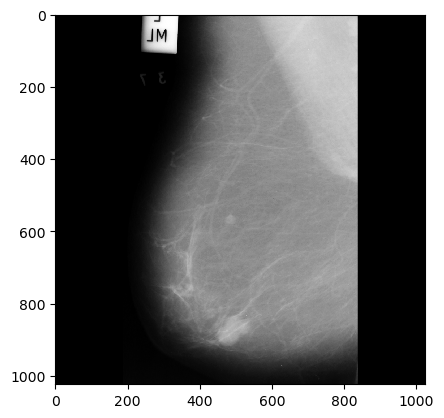

In [21]:
print(pred[0]['boxes'][0])
print(pred[0]['labels'][0])
print(pred[0]['scores'][0])
raw_img_path = img_path
raw_image = io.imread(raw_img_path)
raw_image = np.array(raw_image, dtype=np.float32)
raw_image = raw_image / 4
points = [int(x) for x in pred[0]['boxes'][0][0:4]]
# points = [742, 118, 779, 242]
points[1] = 1024 - points[1]
points[3] = 1024 - points[3]
for k in range(points[0],points[2]):
    for i in range(points[3],points[1]):
        if i >= 0 and k >= 0 and i <= 1024 and k <= 1024:
            raw_image[i][k] *= 4   
plt.imshow(raw_image, interpolation='nearest', cmap='gray')
plt.show()

[842, 118, 879, 242]


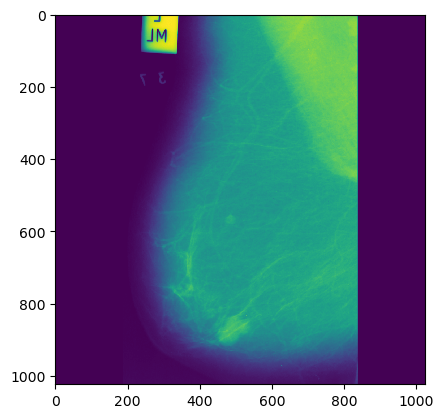

In [22]:
raw_img_path = "all-mias/mdb005.pgm"
raw_image = io.imread(raw_img_path)
raw_image = np.array(raw_image, dtype=np.float32)
raw_image /= 255
raw_image /= 4
points = [int(x) for x in pred[0]['boxes'][0][0:4]]
print(points) 
for k in range(points[0],points[2]):
    for i in range(points[1],points[3]):
        if i >= 0 and k >= 0 and i <= 1024 and k <= 1024:
            raw_image[i][k] *= 4   
plt.imshow(raw_image, interpolation='nearest')
plt.show()

In [16]:
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
labels = [weights.meta['categories'][x] for x in predictions[0]['labels']]
labels

['cat', 'cat', 'dog', 'bed', 'sheep']

In [74]:
model_path = 'resnet50_mias_29092023'
print('saving model...')
torch.save(model.state_dict(), model_path)
print('model saved')


saving model...
model saved


In [ ]:
print('loading model...')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
model.load_state_dict(torch.load(model_path))
print('model loaded')

In [18]:
# For inference
model.eval()
x = torchvision.io.read_image(path='cat.jpg')
x = torch.reshape(x, (1,3,640,612))
x = x /255
predictions = model(x)
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
labels = [weights.meta['categories'][x] for x in predictions[0]['labels']]
labels

['cat', 'cat', 'dog', 'bed', 'sheep']